In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
import nltk
from tqdm import tqdm
import re
from nltk.corpus import stopwords


In [4]:
import pandas as pd
df1 = pd.read_csv('yourpath.csv')

In [5]:

# Converting 'rating_class' to numerical values
df1['rating_class'] = df1['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

# Separating the response variable and feature
X = df1['cleaned_review_text']
y = df1['rating_class']

# Ensure all entries in 'cleaned_review_text' are strings
X = X.astype(str)

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Tokenize the text
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


Found 22403 unique tokens.


In [7]:
from gensim.models import Word2Vec

# Train Word2Vec model
sentences = [seq.split() for seq in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)


(6924297, 7670030)

In [9]:
import numpy as np
# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
from keras.layers import Dropout


# Define the model with Dropout
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dropout(0.5))  # Add Dropout layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
from keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=16, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])


Epoch 1/10
1169/1169 [==============================] - 28s 24ms/step - loss: 0.5147 - accuracy: 0.8218 - val_loss: 0.4306 - val_accuracy: 0.8539
Epoch 2/10
1169/1169 [==============================] - 27s 23ms/step - loss: 0.4144 - accuracy: 0.8530 - val_loss: 0.4943 - val_accuracy: 0.8618
Epoch 3/10
1169/1169 [==============================] - 27s 23ms/step - loss: 0.4023 - accuracy: 0.8602 - val_loss: 0.4983 - val_accuracy: 0.8641
Epoch 4/10
1169/1169 [==============================] - 27s 23ms/step - loss: 0.3954 - accuracy: 0.8679 - val_loss: 0.6326 - val_accuracy: 0.8560


In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy}")


147/147 [==============================] - 1s 7ms/step - loss: 0.6716 - accuracy: 0.8586
Test Accuracy: 0.8585793972015381


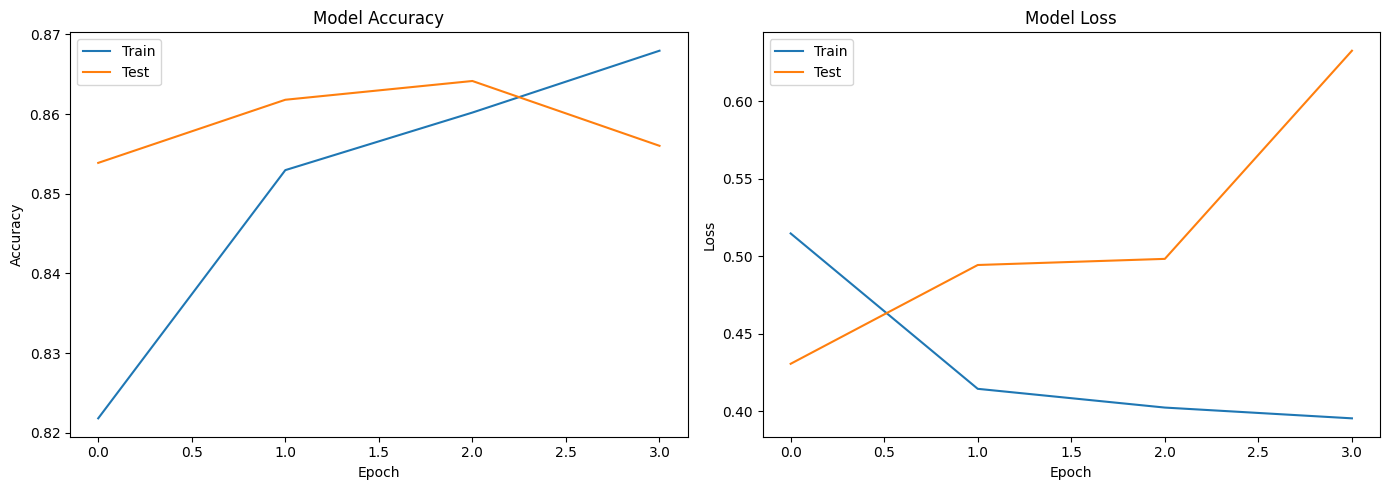

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()
